In this notebook we present some basic application of random forest to
the parameterization of the L96 model previously introduced.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import L96_model_XYtend
from L96_model_XYtend import EulerFwd, RK2, RK4
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t

In [2]:
# Main script parameters
K=8
J=32
FORCING=18
dt=0.01
T_SPINUP=50
T_SIMULATIONS=200


In [3]:
model = L96_model_XYtend.L96(K, J, F=FORCING)
# First run for spin up
model.run(dt, T_SPINUP, store=True)
# The data from the run below will be used both for offline training and testing
X_history, Y_history, t, closure = model.run(dt, T_SIMULATIONS, store=True)

In [4]:
# We will use the quantity below in our online test
var_X = X_history.var()
var_X

20.672715821309936

Scatter-plot of subgrid tendency vs large-scale state X

<IPython.core.display.Javascript object>


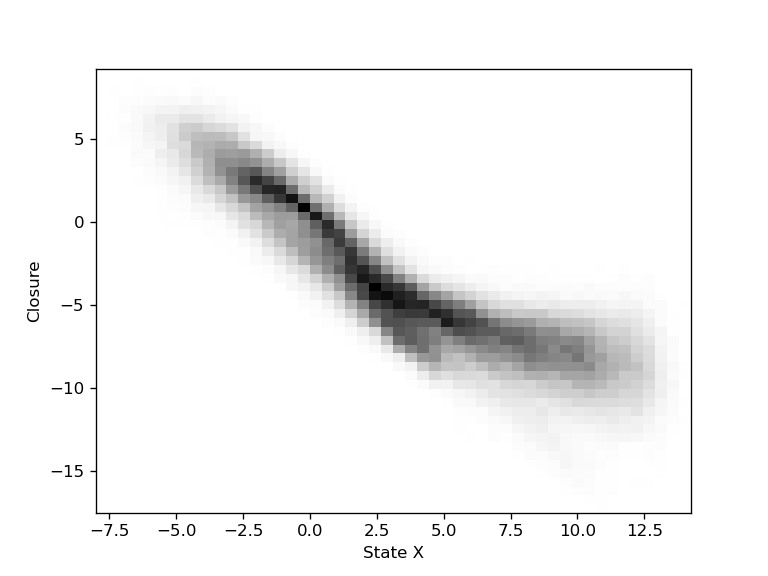

Text(0, 0.5, 'Closure')

In [5]:
plt.figure()
_ = plt.hist2d(X_history.flatten(), closure.flatten(), bins=50, cmap='binary')
plt.xlabel('State X')
plt.ylabel('Closure')

## Starting with a single regression tree

We start with a very simple approach: we use a single value of the state as our feature (i.e. our feature is a scalar), and the subgrid tendency for the same large-scale variable as the target.

### Offline training / fitting and testing

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
closure.shape, X_history.shape

((20001, 8), (20001, 8))

First we split the data into training and test. Since the relation between $X_k$ and its associated subgrid tendency is not expected to depend on $k$, we transform the recorded history into a column vector before splitting.

In [8]:
X_train, X_test, xy_train, xy_test = train_test_split(X_history.flatten().reshape(-1, 1), closure.flatten(), test_size=0.33, shuffle=False)
print(f'X_train has shape: {X_train.shape}')
print(f'xy_train has shape: {xy_train.shape}')

X_train has shape: (107205, 1)
xy_train has shape: (107205,)


Then we define our decision tree. For the sake of the example, we limit the number of leaves to 15. Feel free to increase that number and see how the plot below, showing the true and fitted data, changes. In particular, for larger values, we can see that we overfit the data.

In [9]:
from sklearn import tree
single_tree = tree.DecisionTreeRegressor(max_leaf_nodes=15)
single_tree.fit(X_train, xy_train)

DecisionTreeRegressor(max_leaf_nodes=15)

Here we plot the true training data (the large scale state values on the x-axis, and the parameterization value on the y-axis) and the fitted data.

<IPython.core.display.Javascript object>


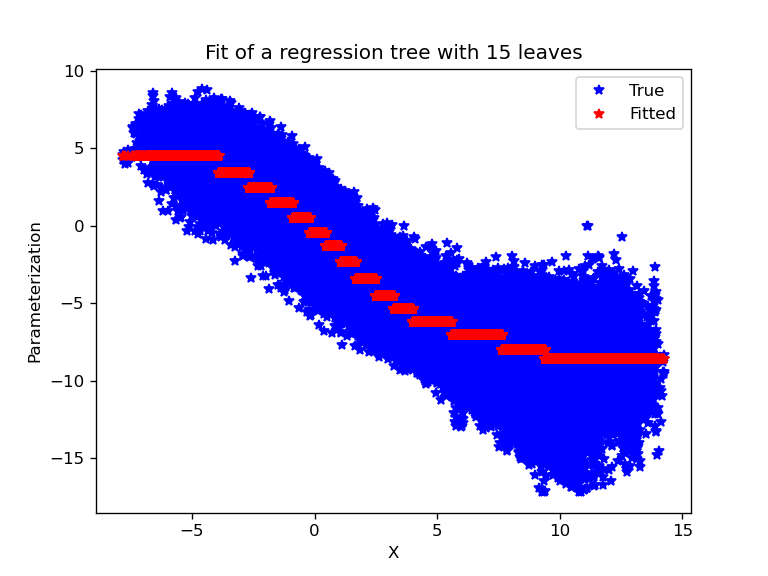

Text(0.5, 1.0, 'Fit of a regression tree with 15 leaves')

In [10]:
plt.figure()
plt.plot(X_train, xy_train, 'b*')
plt.plot(X_train, single_tree.predict(X_train), 'r*')
plt.xlabel('X')
plt.ylabel('Parameterization')
plt.legend(('True', 'Fitted'))
plt.title('Fit of a regression tree with 15 leaves')

Now, same plot but for the test data. The test data has not been seen during the fitting procedure, so in some sense this is the true test. While we may fit very well the training data, overfitting will result in poor performance on the test dataset.

<IPython.core.display.Javascript object>


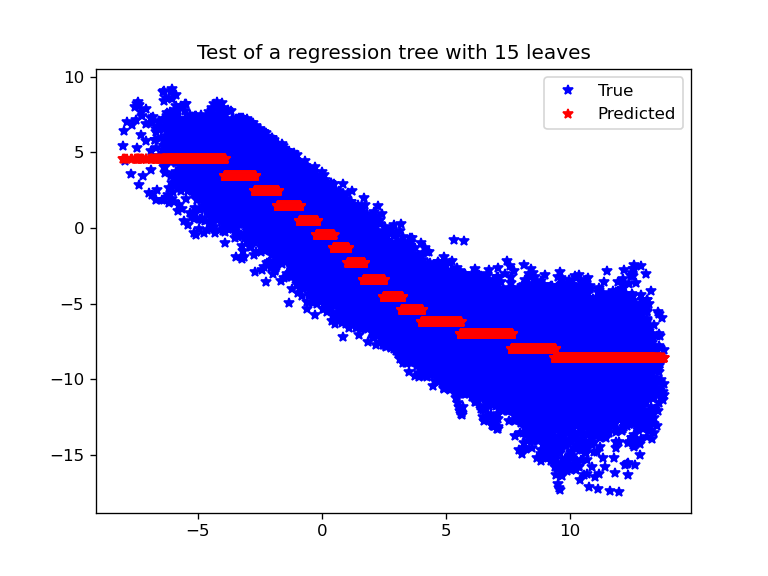

Text(0.5, 1.0, 'Test of a regression tree with 15 leaves')

In [11]:
plt.figure()
plt.plot(X_test, xy_test, 'b*')
plt.plot(X_test, single_tree.predict(X_test), 'r*')
plt.legend(('True', 'Predicted'))
plt.title('Test of a regression tree with 15 leaves')

### Fit and test scores

We can compute the $R^2$ score: $R^2 = 1 - \frac{\sum_{i}{(\hat{S}_i - S_i)^2}}{\sum_{i}{(S_i - S_\text{mean})^2}}$
for both the training data (fit score) and test data.

In [12]:
fit_score = single_tree.score(X_train, xy_train)
test_score = single_tree.score(X_test, xy_test)
print(fit_score, test_score)

0.8594062237241884 0.8592404172827734


<IPython.core.display.Javascript object>


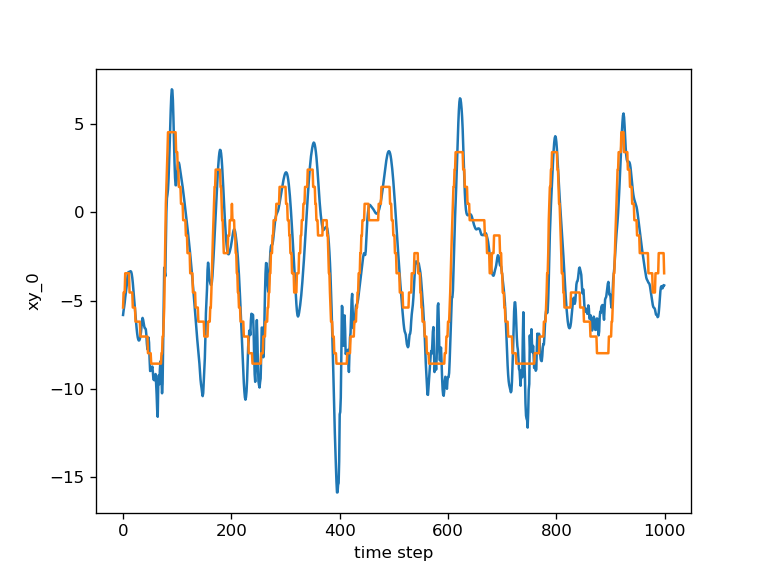

Text(0, 0.5, 'xy_0')

In [13]:
plt.figure()
plt.plot(xy_test[:8000:K])
plt.plot(single_tree.predict(X_test)[:8000:K])
plt.xlabel('time step')
plt.ylabel(r'xy_0')

### Overfitting

To illustrate what is meant by overfitting, we will increase the number of leaves, and store the fit loss and test loss for plotting

In [22]:
nb_leaves = list(map(lambda x: int(np.exp(x / 2)) + 1, range(1, 20)))

<IPython.core.display.Javascript object>


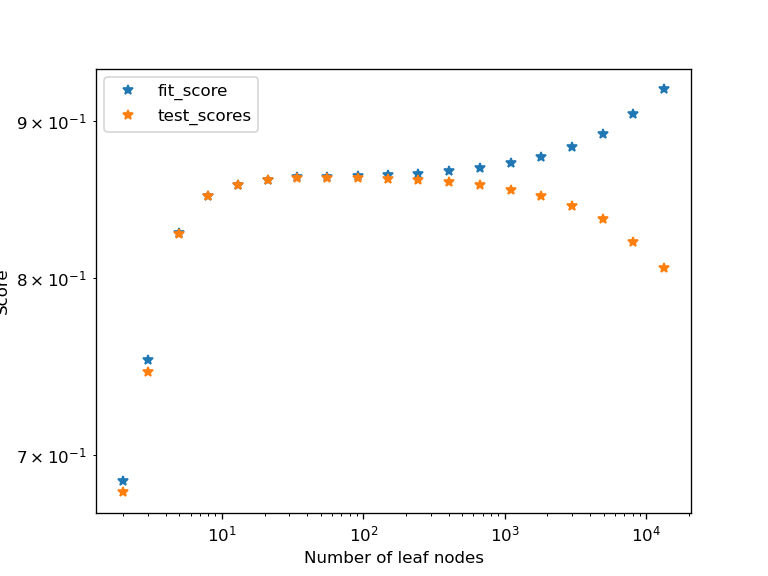

Text(0, 0.5, 'Score')

In [23]:
fit_scores, test_scores = [], []
for nb in nb_leaves:
    current_tree = tree.DecisionTreeRegressor(max_leaf_nodes=nb)
    current_tree.fit(X_train, xy_train)
    fit_scores.append(current_tree.score(X_train, xy_train))
    test_scores.append(current_tree.score(X_test, xy_test))

plt.figure()
plt.loglog(nb_leaves, list(fit_scores), '*')
plt.loglog(nb_leaves, list(test_scores), '*')
plt.legend(('fit_score', 'test_scores'))
plt.xlabel('Number of leaf nodes')
plt.ylabel('Score')

### Online implementation of the parameterization

Now let's implement this as a parameterization for L96.

In [38]:
class Parameterization:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, X):
        X = X.reshape(-1, 1)
        return self.predictor.predict(X)

Here we use the GCM class defined by Yani in his notebook

In [25]:
class GCM:
    def __init__(self, F, parameterization, time_stepping=RK4):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X):
        return L96_eq1_xdot(X, self.F) + self.parameterization(X)
        
    def __call__(self,X0, dt, nt):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [26]:
gcm = GCM(model.F, Parameterization(single_tree))
gcm_no_param = GCM(model.F, lambda x: 0)

In [27]:
n_steps = 2000

In [28]:
def online_test(param, n_runs, n_steps):
    simulations = []
    gcm = GCM(model.F, param)
    for i in range(n_runs):
        if i % 10 == 0:
            print('run ', i)
        X_param, t = gcm(model.X, model.dt, n_steps)
        X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
        X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)
        simulations.append((X_true, X_param))
    squared_errors = np.stack([((true - sim)**2).mean(axis=-1) for true, sim in simulations], axis=0)
    return np.median(squared_errors, axis=0) / var_X

In [29]:
#test = online_test(Parameterization(single_tree), 50, n_steps)

In [30]:
#plt.figure()
#plt.plot(test)

In [31]:
gcm = GCM(model.F, Parameterization(single_tree))
gcm_no_param = GCM(model.F, lambda x: 0)
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


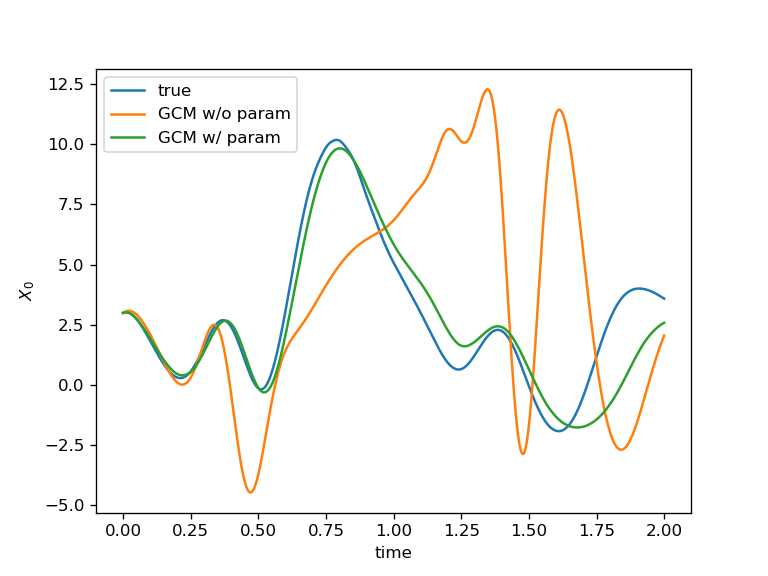

In [32]:
plt.figure()
plt.plot(t, X_true[:, 0], label='true')
plt.plot(t, X_no_param[:, 0], label='GCM w/o param')
plt.plot(t, X_param[:, 0], label='GCM w/ param')
plt.xlabel('time')
plt.ylabel(r'$X_0$')
plt.legend()

## Multiple features

In this section, we use the global state.

In [39]:
single_treeV2 = tree.DecisionTreeRegressor(max_leaf_nodes=300)

In [40]:
X_train, X_test, xy_train, xy_test = train_test_split(X_history, closure[:, 0], test_size=0.33, shuffle=False)

In [41]:
single_treeV2.fit(X_train, xy_train)

DecisionTreeRegressor(max_leaf_nodes=300)

In [42]:
single_treeV2.score(X_train, xy_train)

0.9426299684265214

In [43]:
single_treeV2.score(X_test, xy_test)

0.8676545749969007

<IPython.core.display.Javascript object>


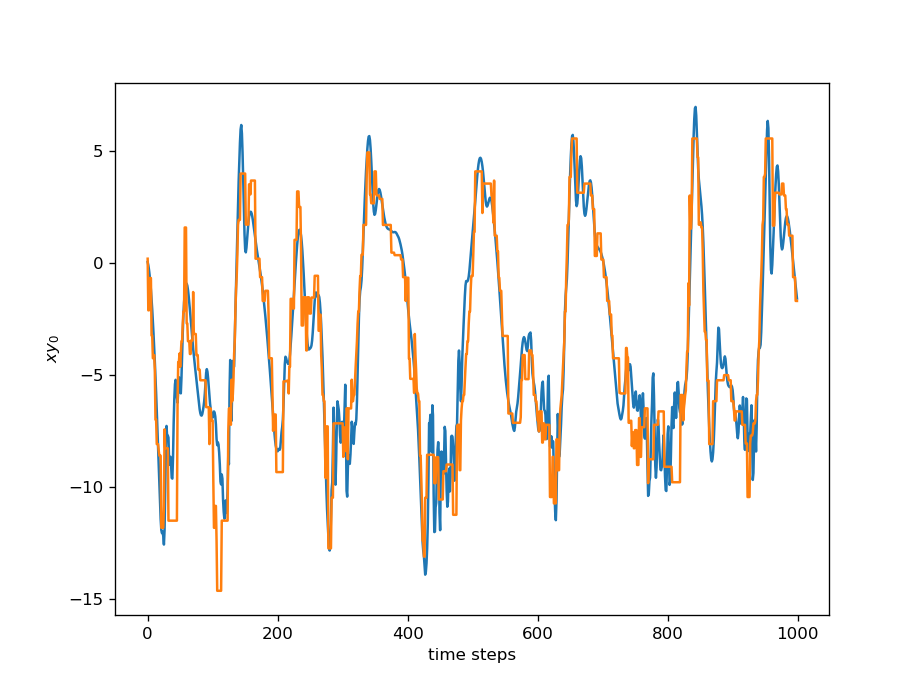

Text(0, 0.5, '$xy_0$')

In [44]:
plt.figure()
plt.plot(xy_test[:1000])
plt.plot(single_treeV2.predict(X_test)[:1000])
plt.xlabel('time steps')
plt.ylabel(r'$xy_0$')

We need to adapt our parameterization so that it makes use of the homogeneity of the problem

In [47]:
class ParameterizationV2:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, X):
        X = X.reshape(1, K)
        new_X = []
        for i in range(K):
            new_X.append(np.roll(X, -i, axis=-1))
        new_X = np.concatenate(new_X, axis=0)
        return self.predictor.predict(new_X)

In [48]:
gcm = GCM(model.F, ParameterizationV2(single_treeV2))
gcm_no_param = GCM(model.F, lambda x: 0)
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


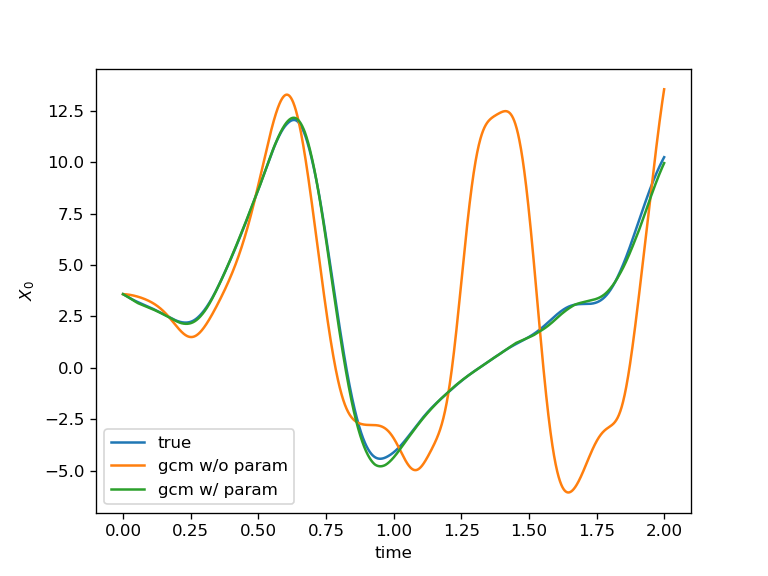

Text(0, 0.5, '$X_0$')

In [49]:
plt.figure()
plt.plot(t, X_true[:, 0])
plt.plot(t, X_no_param[:, 0])
plt.plot(t, X_param[:, 0])
plt.legend(('true', 'gcm w/o param', 'gcm w/ param'))
plt.xlabel('time')
plt.ylabel(r'$X_0$')

In [52]:
#test = online_test(ParameterizationV2(single_treeV2), 50, n_steps)

In [53]:
#plt.figure()
#plt.plot(test)

## Random Forest: ensemble of decision trees

Here we use a random forest instead of a single decision tree. The idea is simple: to avoid overfitting, one trains several decision trees on the same data.  The prediction of the random forest is then the average prediction of all decision trees within the ensemble.

There are two main ways in which the fitted trees within the forest might differ:
- the selected features for the splits: at each iteration of the fitting procedure, the algorithm does not consider all features to select the best split, at least not when the number of features is large. Instead, a finite number of features is considered at random. 
- the data on which they are trained. Below, by setting bootstrap to True and max_samples to 0.5, we specify that each tree within the forest will only be trained on half of the training data

Random forest are an efficient way to avoid overfitting compared to using a single tree. However they do come with a computational and memory cost.

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
# We start with an ensemble of 10 decision trees
rf = RandomForestRegressor(n_estimators=50, max_leaf_nodes=300, bootstrap=True, max_samples=0.5)

We fit to the same training data as in the previous section

In [56]:
rf.fit(X_train, xy_train)

RandomForestRegressor(max_leaf_nodes=300, max_samples=0.5, n_estimators=50)

We can actually get the prediction of each tree within the forest:

In [57]:
tree_predictions = []
for est in rf.estimators_:
    tree_predictions.append(est.predict(X_test[:1, :]))
tree_predictions = np.array(tree_predictions)
print(tree_predictions.flatten())
print(tree_predictions.mean())
print(rf.predict(X_test[:1, :])[0])

[-0.49146987 -1.15560694 -0.23838755 -2.12673799  0.2141356  -1.94025921
 -0.92543731 -0.3817706  -0.05561184 -0.01453032  0.06610048  0.07875124
  0.09596158  0.29768407 -0.47667273 -0.39751296  0.91062313 -1.86908759
 -0.41571687  0.40887702  0.4085568  -0.02366857  0.25608701  0.56139771
  0.00516743 -0.55454002  0.39730779 -0.12934339  0.04171949  0.0215105
  0.07299038 -0.1608794  -1.67959565 -1.67550147  0.00667628  0.49040587
  0.61020285 -0.38935809 -0.14749096  0.31163173 -1.06755272 -0.67113928
 -0.00301096 -0.56439767  1.42999444 -0.70026122 -0.93417319  0.51687637
 -0.05949211  0.705842  ]
-0.2268141338943372
-0.2268141338943372


In [58]:
rf.score(X_train, xy_train), rf.score(X_test, xy_test)

(0.956210755486876, 0.9107759933794404)

<IPython.core.display.Javascript object>


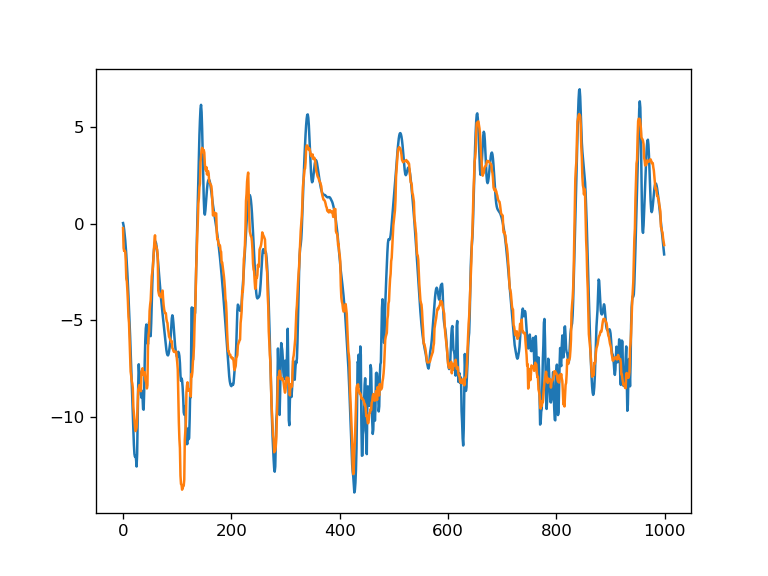

In [59]:
plt.figure()
plt.plot(xy_test[:1000])
plt.plot(rf.predict(X_test)[:1000])

Again, we can test this online.

In [60]:
gcm = GCM(model.F, ParameterizationV2(rf))
gcm_no_param = GCM(model.F, lambda x: 0)

In [61]:
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


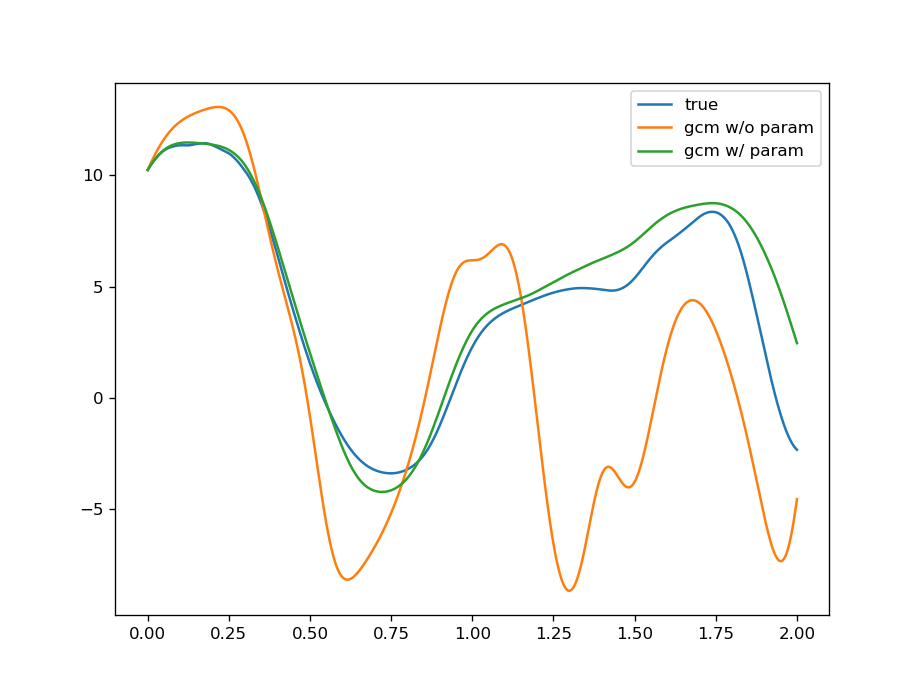

In [62]:
plt.figure()
plt.plot(t, X_true[:, 0])
plt.plot(t, X_no_param[:, 0])
plt.plot(t, X_param[:, 0])
plt.legend(('true', 'gcm w/o param', 'gcm w/ param'))

In [63]:
#test = online_test(ParameterizationV2(rf), 50, n_steps)

In [64]:
#plt.figure()
#plt.plot(test)

## Gradient boosting

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=200)
gbr.fit(X_train, xy_train)
score_train = gbr.score(X_train, xy_train)
score_test = gbr.score(X_test, xy_test)

print(score_train, score_test)

0.9242525458448925 0.9047311463409137


In [66]:
#test = online_test(ParameterizationV2(gbr), 20, n_steps)

In [67]:
#plt.figure()
#plt.plot(test)

## More features: using past state

Here we further increase the complexity of our approach by incorporating past state into the features used to carry out our prediction.

In [68]:
n_times = 2
new_X = X_history.copy()
for i in range(n_times - 1):
    new_X = np.concatenate((new_X, np.roll(X_history, i + 1, axis=0)), axis=1)
new_X = new_X[n_times:]
new_closure = closure[n_times:]

X_train, X_test, xy_train, xy_test = train_test_split(new_X, new_closure[:, 0], test_size=0.33, shuffle=False)
X_train.shape

(13399, 16)

In [69]:
rf.max_leaf_nodes = 350
rf.max_samples = 0.99
rf.n_estimators = 100

In [70]:
rf.fit(X_train, xy_train)

RandomForestRegressor(max_leaf_nodes=350, max_samples=0.99)

In [71]:
rf.score(X_train, xy_train)

0.9656943705486437

In [72]:
rf.score(X_test, xy_test)

0.9127822625984183

Again we need to adapt the form of the parameterization, here so that it records past values of the state for later use.

In [73]:
from collections import deque
class Parameterization:
    def __init__(self, predictor, n_times: int = 5):
        self.predictor = predictor
        self.past_states = deque(maxlen=n_times - 1)
        self.n_times = n_times

    def __call__(self, X):
        X = X.reshape(1, K)
        new_X = []
        for i in range(K):
            new_X.append(np.roll(X, -i, axis=-1))
        new_X = np.concatenate(new_X, 0)
        shape = new_X.shape
        save_X = new_X.copy()
        for i in range(self.n_times - 1):
            try:
                new_X = np.concatenate((new_X, self.past_states[-i - 1]), axis=1)
            except IndexError:
                new_X = np.concatenate((new_X, np.zeros(shape)), axis=-1)
        self.past_states.append(save_X)
        return self.predictor.predict(new_X)

In [74]:
n_steps = 2000
gcm = GCM(model.F, Parameterization(rf, n_times))
gcm_no_param = GCM(model.F, lambda x: 0)
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

In [75]:
plt.figure()
plt.plot(t, X_true[:, 0])
plt.plot(t, X_no_param[:, 0])
plt.plot(t, X_param[:, 0])
plt.legend(('true', 'gcm w/o param', 'gcm w/ param'))
plt.xlabel('time')
plt.ylabel(r'$X_0$')

<IPython.core.display.Javascript object>

Text(0, 0.5, '$X_0$')

In [76]:
#test = online_test(Parameterization(rf, 5), 20, n_steps)

## Comparison with NN parameterization (based on Yani's code)

In [78]:
import torch.nn.functional as FF
import torch.nn as nn
import torch

class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16) # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16) # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs
#         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting. 

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

#- a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch,1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X,0)).double()
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy()) # Adding NN parameterization
        
    def __call__(self,X0, dt, nt , param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X, param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

#Load network
path_load = '/home/arthur/python/NYU/L96_demo/06Different-ML-models/network_3_layers_100_epoches.pth'
nn_3l = Net_ANN().double()
nn_3l.load_state_dict(torch.load(path_load))

<All keys matched successfully>

In [79]:
n_steps = 2000
gcm = GCM(model.F, ParameterizationV2(single_treeV2))
gcm_network = GCM_network(model.F, nn_3l)
X_param, t = gcm(model.X, model.dt, n_steps)
X_network, t = gcm_network(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


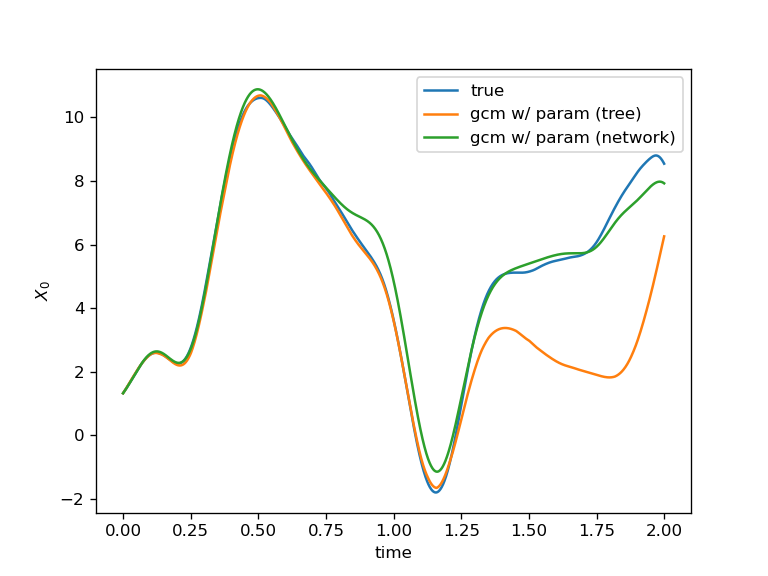

Text(0, 0.5, '$X_0$')

In [80]:
plt.figure()
plt.plot(t, X_true[:, 0])
plt.plot(t, X_param[:, 0])
plt.plot(t, X_network[:, 0])
plt.legend(('true', 'gcm w/ param (tree)', 'gcm w/ param (network)'))
plt.xlabel('time')
plt.ylabel(r'$X_0$')

## Which model / model parameters should we go for?

### Standard Machine Learning approach: validation

The Machine Learning approach to this problem is to separate the data into three data sets:
- training dataset
- validation dataset
- test dataset

Only data from the training dataset is used for fitting. The validation dataset is then used for model selection and hyperparameters tuning: we select the model whose performance on the validation dataset is best.

In order to choose hyperparameters, one needs to make a decision on what set of values to try. One approach is to try a grid of values. Another approach is to try random values. This is recommanded when the possible number of hyperparameter combinations is large. Finally Bayesian approaches to this problem are also popular.

Here we shall implement the random approach: for each model, we will define a range of values for each parameter we wish to tune. We will randomly select a combination of parameter values, fit the model to the training dataset, and assess its performance on the validation dataset. The combination of values leading to the best validation score will be retained. 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

single_tree_params_dist = {
    'max_leaf_nodes' : list(map(int, 1 +np.exp(np.arange(11)))),
}

rf_params_dist = {
    'max_leaf_nodes': list(map(int, 1 +np.exp(np.arange(13)))),
    'n_estimators': np.arange(10) * 50,
}

X_train, X_test, xy_train, xy_test = train_test_split(features(X_history), closure[:, 0], test_size=0.33)

best_single_treeV2 = RandomizedSearchCV(single_treeV2, single_tree_params_dist, n_iter=10, verbose=True)
best_rf = RandomizedSearchCV(rf, rf_params_dist, n_iter=20, verbose=True)

best_single_treeV2.fit(X_train, xy_train)
best_rf.fit(X_train, xy_train)

In [65]:
best_single_treeV2.best_score_

0.9091268379949927

In [66]:
best_single_treeV2.best_params_

{'max_leaf_nodes': 1097}

In [67]:
best_rf.best_params_

{'n_estimators': 300, 'max_leaf_nodes': 59875}

In [68]:
best_rf.score(X_test, xy_test)

0.9569100127411481